In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels

In [3]:
from fastai.vision.gan import *

In [5]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [6]:
# we wrap cadene model to pytorch models format
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [19]:
BATCH_SIZE = 64
sz = 256
NUM_WORKERS = 16
model_name = '20190803-10-normalized_se_resnext50_GAN'

In [31]:
df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
df.head()

patchId  \
patchId                                
73001638400004608  73001638400004608   
73001728000015104  73001728000015104   
60001168640058752  60001168640058752   
52000313600096384  52000313600096384   
42000642560039168  42000642560039168   

                                                        fileName  center  \
patchId                                                                    
73001638400004608  data/training/center_3/patient_073_node_1.tif       3   
73001728000015104  data/training/center_3/patient_073_node_1.tif       3   
60001168640058752  data/training/center_3/patient_060_node_2.tif       3   
52000313600096384  data/training/center_2/patient_052_node_1.tif       2   
42000642560039168  data/training/center_2/patient_042_node_1.tif       2   

                   patient  node  centerX  centerY  isTumor  tumorPercentage  \
patchId                                                                        
73001638400004608       73     1   163840     4608     True             99.9   
73001728000015104       73     1   172800    15104     True             99.9   
60001168640058752       60     2   116864    58752    False              0.0   
52000313600096384       52     1    31360    96384     True             99.9   
42000642560039168       42     1    64256    39168    False              0.0   

                   tissuePercentage  meanHue  meanSaturation  meanValue  \
patchId                                                                   
73001638400004608             100.0     0.76            0.39       0.67   
73001728000015104             100.0     0.76            0.40       0.66   
60001168640058752             100.0     0.72            0.15       0.93   
52000313600096384             100.0     0.87            0.34       0.76   
42000642560039168             100.0     0.79            0.36       0.81   

                   tumorLabel  
patchId                        
73001638400004608        True  
73001728000015104        True  
60001168640058752       False  
52000313600096384        True  
42000642560039168       False

In [32]:
data_folder = './data/norm_patches/'
paths = [data_folder + str(patch) + '_2.png' for patch in df.patchId]
df['path'] = paths
df = df.set_index('path',drop=False)
df = df.drop(columns=['patchId','fileName','center','node','centerX','centerY',
                      'isTumor','tumorPercentage','tissuePercentage','meanHue',
                     'patient','meanSaturation','meanValue','tumorLabel'])
df.head()

path
path                                                                                    
./data/norm_patches/73001638400004608_2.png  ./data/norm_patches/73001638400004608_2.png
./data/norm_patches/73001728000015104_2.png  ./data/norm_patches/73001728000015104_2.png
./data/norm_patches/60001168640058752_2.png  ./data/norm_patches/60001168640058752_2.png
./data/norm_patches/52000313600096384_2.png  ./data/norm_patches/52000313600096384_2.png
./data/norm_patches/42000642560039168_2.png  ./data/norm_patches/42000642560039168_2.png

In [33]:
#data = ImageDataBunch.from_df(path='.',df=df, fn_col='path')
#data.show_batch()

In [34]:
def get_data(bs, size):
    return (GANItemList.from_df(path='.',df=df, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

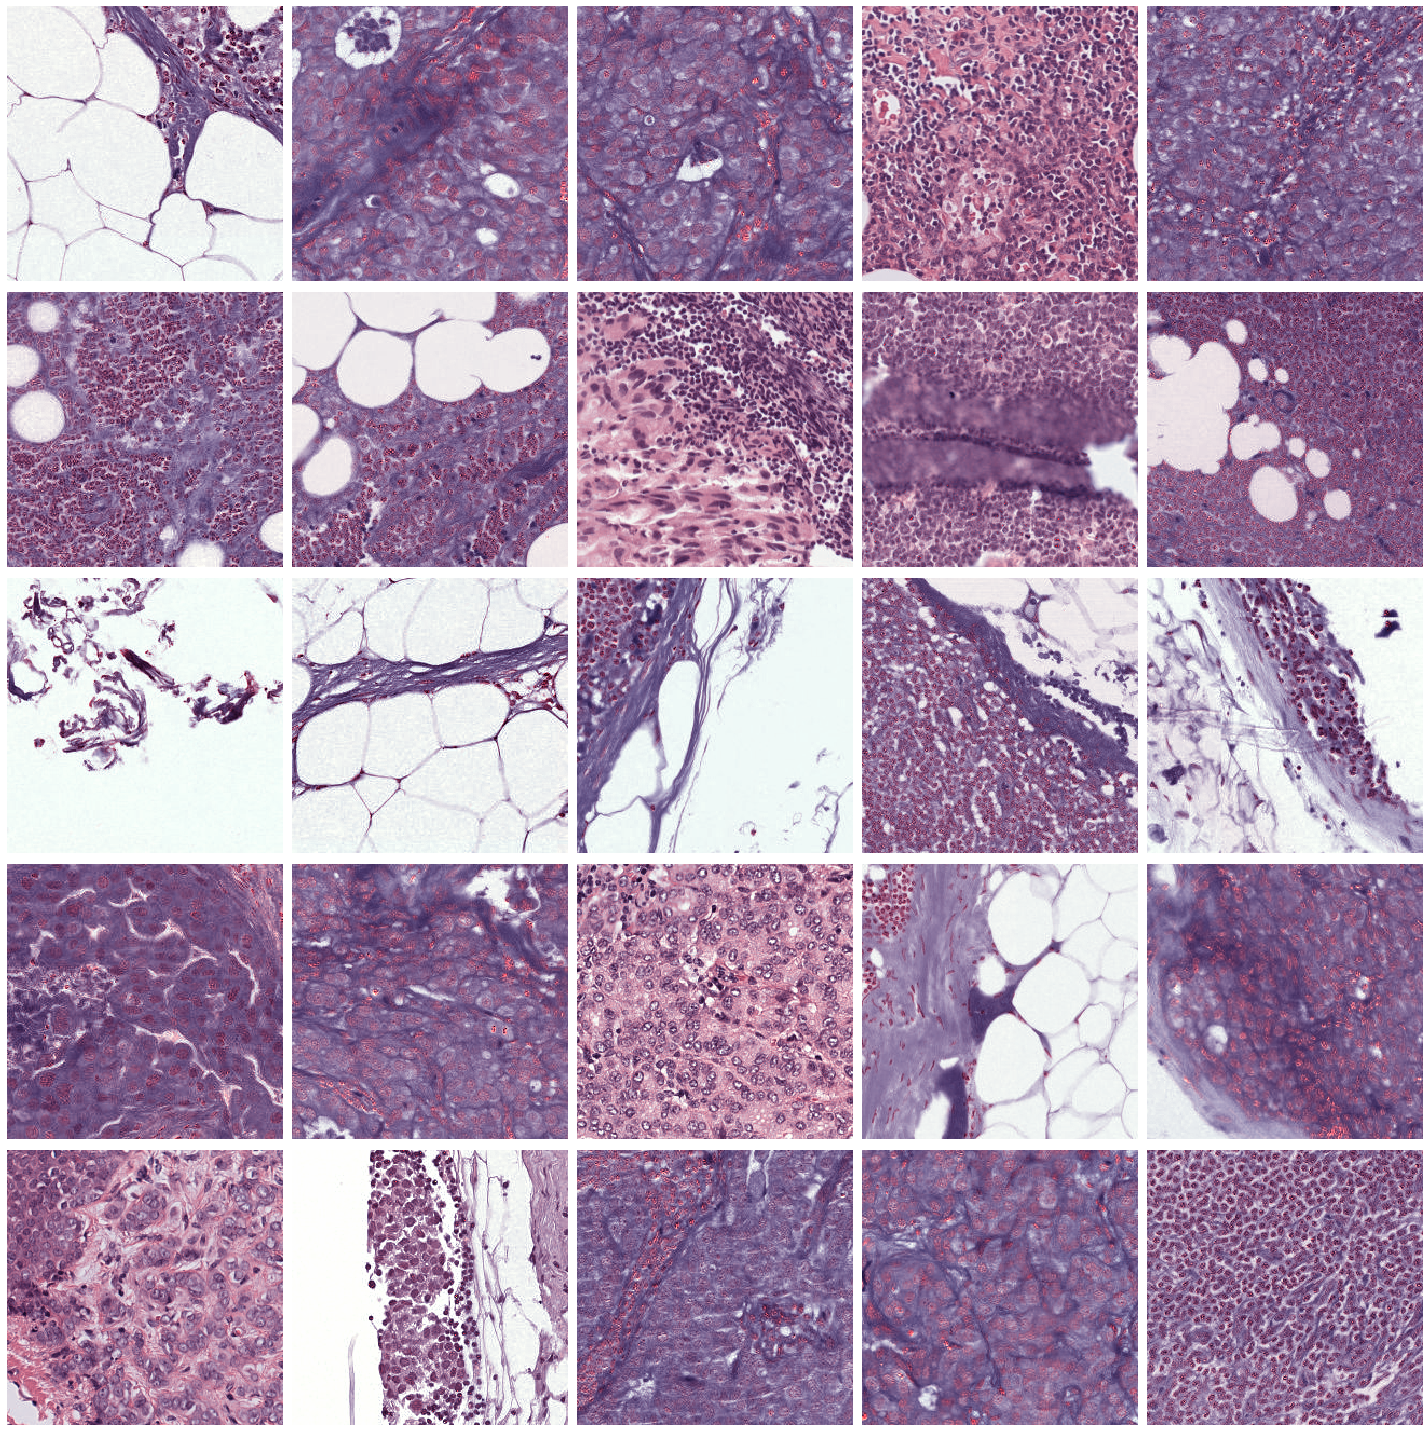

In [35]:
data = get_data(BATCH_SIZE, sz)
data.show_batch(rows=5)

## Baseline WGAN

In [40]:
generator = basic_generator(in_size=sz, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=sz, n_channels=3, n_extra_layers=1)

In [46]:
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4),

In [41]:
learner = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

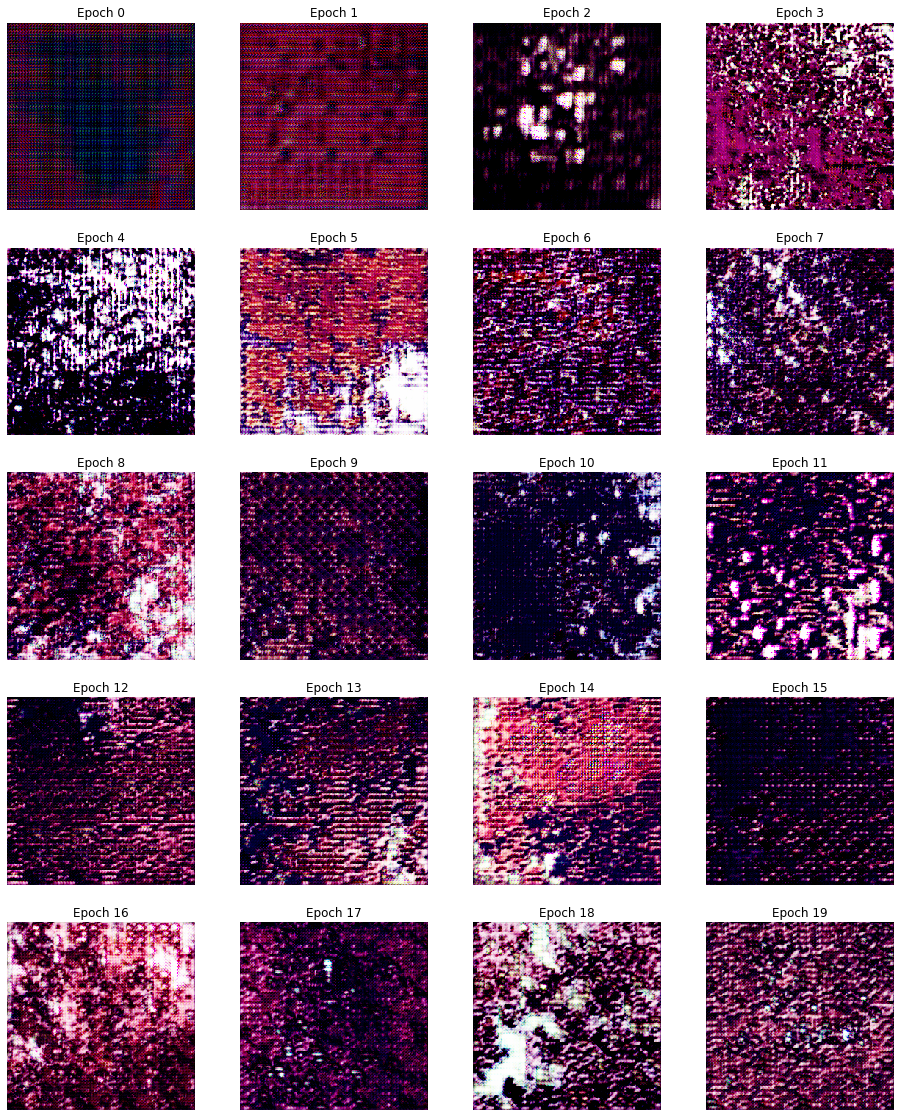

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [ ]:
learner.fit(20,1e-3)

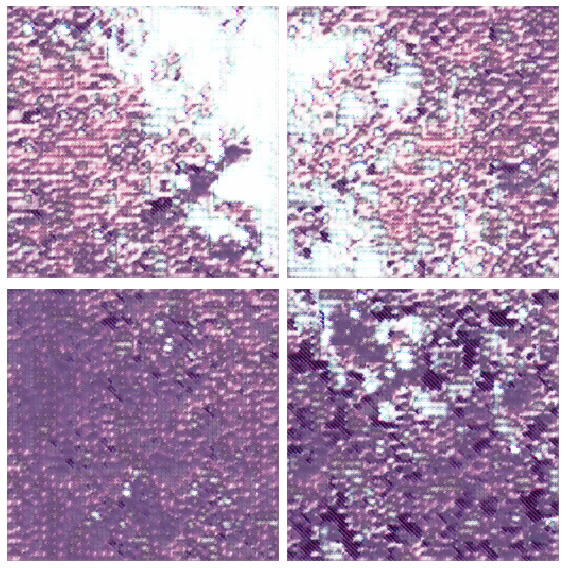

In [45]:
learner.gan_trainer.switch(gen_mode=True)
learner.show_results(ds_type=DatasetType.Train, rows=2, figsize=(8,8))

Doesn't look promising. Perhaps better luck with autoencoders.